In [0]:
import numpy as np
import gym
import random
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files

In [0]:
env = gym.make("FrozenLake8x8-v0")
action_num = env.action_space.n
obs_num = env.observation_space.n

In [0]:
# Learning Parameters
episodes_num = 30
learning_rate = 0.1
max_steps = 299
discount = 0.96
epsilon = 1.0
epsilon_min = 0.1
epsilon_max = 1.0
decay_rate = 0.001

recenter_num = 5
recenter_ep = 500

In [0]:
q_tables = []
for i in range(recenter_num):
  q_tables.append(np.zeros((obs_num, action_num)))

Q_table = np.zeros((obs_num, action_num))

In [0]:
def greedy(eps):
  pivot = random.uniform(0, 1)
  return pivot > eps

In [0]:
def train_estimates(q_tab, epi_num, eps, l_r, show_steps = False):
  # rewards = []
  # steps_till_success = []

  for episode in range(epi_num):

    state = env.reset()
    reward = 0
    step = 300
    done = False
    cumul_rewards = 0

    for step in range(max_steps):
      # env.render()

      # Choose an action
      if greedy(eps):
        action = np.argmax(q_tab[state,:])
      else:
        action = env.action_space.sample()

      # Perform it
      new_state, reward, done, _ = env.step(action)

      if reward == 0 and done == True:
        reward = -1
      elif done == False:
        reward = 0
      else:
        reward = 1

      # Update q-table
      q_tab[state, action] = q_tab[state, action] + l_r * (reward + 
                    discount * np.max(q_tab[new_state, :]) - q_tab[state, action])
      state = new_state

      cumul_rewards += reward
      if reward > 0:
        steps_till_success.append(step + 1)

      if done == True:
        break

    # env.render()
    # if cumul_rewards < 1:
    #   steps_till_success.append(max_steps + 1)
    eps = epsilon_min + (epsilon_max - epsilon_min)*np.exp(-decay_rate * episode) 
    # rewards.append(cumul_rewards)
    # print("**********************************************************************")

  env.close()

  if show_steps == True:
    print(f'Average reward:{sum(rewards)/epi_num}')
    print(f'Min step to success: {min(steps_till_success)}')

  return q_tab

In [0]:
def train(q_tab, qk_tab, estimate, epi_num, eps, l_r, show_steps = False):

  state = env.reset()
  reward = 0
  step = 300
  done = False
  cumul_rewards = 0
  # env.render()

  for stp in range(max_steps):
    # Choose an action
    if greedy(eps):
      action = np.argmax(q_tab[state,:])
    else:
      action = env.action_space.sample()

    # Perform it
    new_state, reward, done, _ = env.step(action)

    if reward == 0 and done == True:
      reward = -1
    elif done == False:
      reward = 0
    else:
      reward = 1

    # Update q-table
    # l_rate = 1/(1 + (1 - discount) * episode)
    q_tab[state, action] = q_tab[state, action] + l_r * (reward + 
                  discount * np.max(q_tab[new_state, :]) - q_tab[state, action])
    state = new_state

    if reward > 0:
       step = stp

    if done == True:
      break

  # env.render()
  q_tab = q_tab - qk_tab + estimate
  eps = epsilon_min + (epsilon_max - epsilon_min)*np.exp(-decay_rate * episode) 
  # print("**********************************************************************")

  env.close()

  # print(steps_till_success)
  if show_steps == True:
    print(f'Average reward:{sum(rewards)/epi_num}')
    print(f'Min step to success: {min(steps_till_success)}')

  return q_tab, step, eps

In [0]:
def evaluate_table(Q_table) :

  total_reward = 0
  steps = []

  for episode in range(10):
    state = env.reset()
    step = 0
    done = False

    for step in range(max_steps):
        
        action = np.argmax(Q_table[state,:])
        
        new_state, reward, done, info = env.step(action)

        total_reward += reward
        
        if done:
          if reward > 0:
            steps.append(step + 1)
          # else:
          #   step.append(max_steps + 1)
          break
        state = new_state
  env.close()
  return total_reward / 10, np.mean(steps)

In [111]:
%%time

steps_till_success = []
success_rate = []
for episode in range(episodes_num):
  l_r = learning_rate / (episode + 1)
  step_episode = []
  print("**********************************************************************")
  print(f'EPISODE {episode + 1}')
  # print(Q_table)
  q_est = np.zeros((obs_num, action_num))

  for i in range(recenter_num):
    q_tables[i] = Q_table
    q_tables[i] = train_estimates(q_tables[i], recenter_ep, epsilon, l_r, False)

  for i in range(recenter_num):
    q_est = q_est + q_tables[i]
  q_est = q_est / recenter_num

  rate, step = evaluate_table(Q_table)
  success_rate.append(rate)
  steps_till_success.append(step)

  for i in range(recenter_num):
    Q_table, step, epsilon = train(Q_table, q_tables[i], q_est, epsilon, l_r, False)
    rate, step = evaluate_table(Q_table)
    success_rate.append(rate)
    steps_till_success.append(step)
    # step_episode.append(step)
    
  # print(step_episode)
  # steps_till_success.extend(step_episode)

**********************************************************************
EPISODE 1
**********************************************************************
EPISODE 2
**********************************************************************
EPISODE 3
**********************************************************************
EPISODE 4
**********************************************************************
EPISODE 5
**********************************************************************
EPISODE 6
**********************************************************************
EPISODE 7
**********************************************************************
EPISODE 8
**********************************************************************
EPISODE 9
**********************************************************************
EPISODE 10
**********************************************************************
EPISODE 11
**********************************************************************
EPISODE 12
*************************

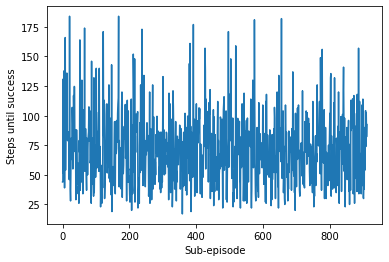

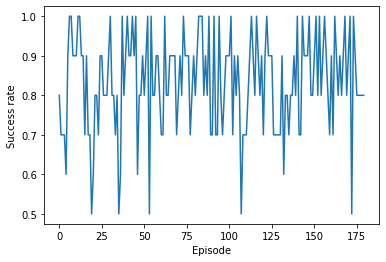

In [112]:
# print(steps_till_success)
plt.plot(steps_till_success)
plt.xlabel('Sub-episode')
plt.ylabel('Steps until success')
plt.show()
# print(success_rate)
plt.plot(success_rate)
plt.xlabel('Episode')
plt.ylabel('Success rate')
plt.show()

In [113]:
total_reward = 0
steps = []

for episode in range(1000):
    state = env.reset()
    step = 0
    done = False

    for step in range(max_steps):
        
        action = np.argmax(Q_table[state,:])
        
        new_state, reward, done, info = env.step(action)

        total_reward += reward
        
        if done:
          if reward > 0:
            steps.append(step + 1)
          # else:
          #   step.append(max_steps + 1)
          break
        state = new_state
env.close()

print(f'Successful runs out of 1000: {total_reward}')
print(f'Average steps: {np.mean(steps)}')
print(np.var(steps))

Successful runs out of 1000: 886.0
Average steps: 84.37358916478556
1444.267880345887


In [0]:
df1 = pd.DataFrame()
df1['steps'] = steps_till_success
df2 = pd.DataFrame()
df2['success_rate'] = success_rate
df1.to_csv('Q_tab_var_red_FL8x8_100_30_steps.csv')
df2.to_csv('Q_tab_var_red_FL8x8_100_30_rates.csv')
files.download(r'Q_tab_var_red_FL8x8_100_30_steps.csv')
files.download('Q_tab_var_red_FL8x8_100_30_rates.csv')